# HW 3 - Synonym Detection In Spark
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the last homework assignment you performed Naive Bayes to classify documents as 'ham' or 'spam.' In doing so, we relied on the implicit assumption that the list of words in a document can tell us something about the nature of that document's content. We'll rely on a similar intuition this week: the idea that, if we analyze a large enough corpus of text, the list of words that appear in small window before or after a vocabulary term can tell us something about that term's meaning.

This will be your first assignment working in Spark. You'll perform Synonym Detection by repurposing an algorithm commonly used in Natural Language Processing to perform document similarity analysis. In doing so you'll also become familiar with important datatypes for efficiently processing sparse vectors and a number of set similarity metrics (e.g. Cosine, Jaccard, Dice). By the end of this homework you should be able to:  
* ... __define__ the terms `one-hot encoding`, `co-occurrance matrix`, `stripe`, `inverted index`, `postings`, and `basis vocabulary` in the context of both synonym detection and document similarity analysis.
* ... __explain__ the reasoning behind using a word stripe to compare word meanings.
* ... __identify__ what makes set-similarity calculations computationally challenging.
* ... __implement__ stateless algorithms in Spark to build stripes, inverted index and compute similarity metrics.
* ... __apply__ appropriate metrics to assess the performance of your synonym detection algorithm. 


__`NOTE`__: your reading assignment for weeks 5 and 6 were fairly heavy and you may have glossed over the papers on dimension independent similarity metrics by [Zadeh et al](http://stanford.edu/~rezab/papers/disco.pdf) and pairwise document similarity by [Elsayed et al](https://terpconnect.umd.edu/~oard/pdf/acl08elsayed2.pdf). If you haven't already, this would be a good time to review those readings -- they are directly relevant to this assignment.

__Please refer to the `README` for homework submission instructions and additional resources.__ 

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session (RUN THIS CELL AS IS)
from pyspark.sql import SparkSession
app_name = "hw3_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [5]:
# Spark configuration Information (RUN THIS CELL AS IS)
sc.getConf().getAll()

[('spark.driver.port', '46789'),
 ('spark.app.name', 'hw3_notebook'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.app.id', 'local-1560396809165'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', 'docker.w261')]

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Spark Basics.
In your readings and live session demos for weeks 4 and 5 you got a crash course in working with Spark. We also talked about how Spark RDDs fit into the broader picture of distributed algorithm design. The questions below cover key points from these discussions. Feel free to answer each one very briefly.

### Q1 Tasks:

* __a) short response:__ What is Spark? How  does it relate to Hadoop MapReduce?

* __b) short response:__ In what ways does Spark follow the principles of statelessness (a.k.a. functional programming)? List at least one way in which it allows the programmer to depart from this principle. 

* __c) short response:__ In the context of Spark what is a 'DAG' and how do they relate to the difference between an 'action' and a 'transformation'? Why is it useful to pay attention to the DAG that underlies your Spark implementation?

* __d) short response:__ Give a specific example of when we would want to `cache()` an RDD and explain why.

* __e) environment:__ List your environment configuration in which you will be working for this assignment, including OS, Number of Cores, CPUs, Memory. Are you using Docker? Are you running in the cloud (what is your cloud Spark configuration)? (If you are working on a Mac, you can use the these commands to get the system configuration: `sw_vers` and `system_profiler SPHardwareDataType`).

### Q1 Student Answers:
> __a)__ Apache Spark is a distributed computing framework that can be utilized to implement MapReduce jobs/tasks up to 100x faster than using Hadoop MapReduce.  It uses memory backed data blocks accessible through the Resilient Distributed Dataset (RDD) object which has over 80 APIs compared to 2 for Hadoop MapReduce for performing variants of the Map and Reduce functions known as transformations and actions.  Lastly, Apache Spark uses a DAG execution framework with lazy evaluation to ensure that the most optimal execution plan is computed when running Spark jobs.

> __b)__ Apache Spark fits into the functional programming paradigm by not modifying the data it is working on directly, but instead creating new structures when modified.  It uses lazy evaluation to optimize its execution which ultimately means no computations are made until necessary.  Apacke Spark is not entirely functional since there can be side effects resulting in changed state not from function inputs.

> __c)__ In Apache Spark, a Directed Acyclic Graph (DAG) is used for defining the executions of a given spark job.  Transformations will add onto the DAG without being executed while Actions will add onto the DAG and require executing up to the Action.  In other words, the DAG can continue to map out transformations until it reaches an action.  The underlying DAG determines the execution plan for the spark job, thus it ultimately determines what work will be done by Spark.  Moreover, all Spark code written will be optimized down to a single DAG of execution.

> __d)__ We would want to cache() an RDD when we have many upstream transformations prior to an action.  One example scenario would be trying to determine how "happy" tweets were sent yesterday, and we have a file in HDFS of tweets from around the globe.  We would need to load the HDFS file into a HadoopRDD, apply a filter transformation for time to be yesterday, apply a second filter for the word "happy", and finally use a save action to keep our results.  Without caching, the save action would trigger a callback all the way to the HadoopRDD load step per line until the file is finished processing.  Applying a cache() after the first filter for time would allow the save action to only have to make callbacks up to the time filter RDD, thus saving execution time and making our job more efficient.

> __e)__ OS: Windows 10 Eduction, # of Cores: 4, CPUs: 1, Memory: 8GB, Docker: Class docker image (w261/w261-environment:latest), Running in the cloud:  No

# Question 2: Similarity Metrics
As mentioned in the introduction to this assignment, an intuitive way to compare the meaning of two documents is to compare the list of words they contain. Given a vocabulary $V$ (feature set) we would represent each document as a vector of `1`-s and `0`-s based on whether or not it contains each word in $V$. These "one-hot encoded" vector representations allow us to use math to identify similar documents. However like many NLP tasks the high-dimensionality of the feature space is a challenge... especially when we start to scale up the size and number of documents we want to compare.

In this question we'll look at a toy example of document similarity analysis. Consider these 3 'documents': 
```
docA	the flight of a bumblebee
docB	the length of a flight
docC	buzzing bumblebee flight
```
These documents have a total of $7$ unique words: 
>`a, bumblebee, buzzing, flight, length, of, the`.     

Given this vocabulary, the documents' vector representations are (note that one-hot encoded entries follow the order of the vocab list above):

```
docA	[1,1,0,1,0,1,1]
docB	[1,0,0,1,1,1,1]
docC	[0,1,1,1,0,0,0]
```  

### Q2 Tasks:

* __a) short response:__ The cosine similarity between two vectors is $\frac{A\cdot B}{|A||B|}$. Explain what the the numerator and denominator of this calculation would represent in terms of word counts in documents A and B. 

* __b) short response:__ Explain how the Jaccard, Overlap and Dice metrics are similar/different to the calculation for cosine similarity. When would these metrics lead to different similarity rankings for a set of documents?

* __c) short response:__ Calculate the cosine similarity for each pair of documents in our toy corpus. Please use markdown and $\LaTeX$ to show your calcuations.  

* __d) short response:__ According to your calculations in `part c` which pair of documents are most similar in meaning? Does this match your expecatation from reading the documents? If not, speculate about why we might have gotten this result.

* __e) short response:__ In NLP common words like '`the`', '`of`', and '`a`' increase our feature space without adding a lot of signal about _semantic meaning_. Repeat your analysis from `part c` but this time ignore these three words in your calculations [__`TIP:`__ _to 'remove' stopwords just ignore the vector entries in columns corresponding to the words you wish to disregard_]. How do your results change?

### Q2 Student Answers:
> __a)__ In our example, the numerator of the cosine similarity calculation would represent the term frequency vector of document A multiplied by the term frequency vector of document B.  The denominator of this calculation would represent the square root of the sum of all document A terms squared multplied by the square root of the sum of all document B terms squared.  Thus, the equation ultimately yields a cosine similarity output ranging from -1 to 1 where 1 represents the documents being identical.  

> __b)__ The Jaccard metric is similar to the Cosine calculation in that their numerators are the same (e.g. multiplication of both document's vectors together), but they differ in that Jaccard relies on the union of the document vectors for calculating the denominator.  Similarly, the Overlap metric is similar to the Cosine calculation in that their numerators are the same (e.g. multiplication of both document's vectors together), but the Overlap denominator calculation is different by using the size of the smallest document vector.  Finally, the Dice metric is similar to the Cosine calculation in that they rely on the same intersection calculation between document A and B for the numerator, however Dice doubles this numerator calculation and also uses the sum of the term count for document A and B for the denominator calculation.

> __c)__ $cos\_sim(A,B) = \frac{1*1 + 1*0 + 0*0 + 1*1 + 0*1 + 1*1 + 1*1}{\sqrt{1^2+1^2+0^2+1^2+0^2+1^2+1^2} * \sqrt{1^2+0^2+0^2+1^2+1^2+1^2+1^2}} = \frac{1 + 1 + 1 + 1}{\sqrt{1+1+1+1+1} * \sqrt{1+1+1+1+1}} = \frac{4}{\sqrt{5} * \sqrt{5}} = \frac{4}{5} = 0.8 $ $cos\_sim(A,C) = \frac{1*0 + 1*1 + 0*1 + 1*1 + 0*0 + 1*0 + 1*0}{\sqrt{1^2+1^2+0^2+1^2+0^2+1^2+1^2} * \sqrt{0^2+1^2+1^2+1^2+0^2+0^2+0^2}} = \frac{1 + 1}{\sqrt{1+1+1+1+1} * \sqrt{1+1+1}} = \frac{2}{\sqrt{5} * \sqrt{3}} = 0.516 $ $cos\_sim(B,C) = \frac{1*0 + 0*1 + 0*1 + 1*1 + 1*0 + 1*0 + 1*0}{\sqrt{1^2+0^2+0^2+1^2+1^2+1^2+1^2} * \sqrt{0^2+1^2+1^2+1^2+0^2+0^2+0^2}} = \frac{1}{\sqrt{1+1+1+1+1} * \sqrt{1+1+1}} = \frac{1}{\sqrt{5} * \sqrt{3}} = 0.258 $ 

> __d)__ According to my calculations from part c, document A and B are the most similar in meaning.  This matches my expectations since document A and B share all the same words except for 1 difference.  The primary difference between the 2 documents is the order of the words, but the term vectors eliminate the word ordering concern.  

> __e)__ After removing stop words, $docA = [1,0,1,0]$, $docB = [0,0,1,1]$, $docC = [1,1,1,0]$
$cos\_sim(A,B) = \frac{1*0 + 0*0 + 1*1 + 0*1}{\sqrt{1^2+0^2+1^2+0^2} * \sqrt{0^2+0^2+1^2+1^2}} = \frac{1}{\sqrt{1+1} * \sqrt{1+1}} = \frac{1}{\sqrt{2} * \sqrt{2}} = \frac{1}{2} = 0.5 $ $cos\_sim(A,C) = \frac{1*1 + 0*1 + 1*1 + 0*0}{\sqrt{1^2+0^2+1^2+0^2} * \sqrt{1^2+1^2+1^2+0^2}} = \frac{1 + 1}{\sqrt{1+1} * \sqrt{1+1+1}} = \frac{2}{\sqrt{2} * \sqrt{3}} = 0.816 $ $cos\_sim(B,C) = \frac{0*1 + 0*1 + 1*1 + 1*0}{\sqrt{0^2+0^2+1^2+1^2} * \sqrt{1^2+1^2+1^2+0^2}} = \frac{1}{\sqrt{1+1} * \sqrt{1+1+1}} = \frac{1}{\sqrt{2} * \sqrt{3}} = 0.408 $ 

# Question 3: Synonym Detection Strategy

In the Synonym Detection task we want to compare the meaning of words, not documents. For clarity, lets call the words whose meaning we want to compare `terms`. If only we had a 'meaning document' for each `term` then we could easily use the document similarity strategy from Question 2 to figure out which `terms` have similar meaning (i.e. are 'synonyms'). Of course in order for that to work we'd have to reasonably believe that the words in these 'meaning documents' really do reflect the meaning of the `term`. For a good analysis we'd also need these 'meaning documents' to be fairly long -- the one or two sentence dictionary definition of a term isn't going to provide enough signal to distinguish between thousands and thousands of `term` meanings.

This is where the idea of co-occurrance comes in. Just like DocSim makes the assumption that words in a document tell us about the document's meaning, we're going to assume that the set of words that 'co-occur' within a small window around our term can tell us some thing about the meaning of that `term`. Remember that we're going to make this 'co-words' list (a.k.a. 'stripe') by looking at a large body of text. This stripe is our 'meaning document' in that it reflects all the kinds of situations in which our `term` gets used in real language. So another way to phrase our assumption is: we think `terms` that get used to complete lots of the same phrases probably have related meanings. This may seem like an odd assumption but computational linguists have found that it works surprisingly well in practice. Let's look at a toy example to build your intuition for why and how.

Consider the opening line of Charles Dickens' _A Tale of Two Cities_:

In [19]:
corpus = """It was the best of times, it was the worst of times, 
it was the age of wisdom it was the age of foolishness"""

There are a total of 10 unique words in this short 'corpus':

In [20]:
words = list(set(re.findall("\w+", corpus.lower())))
print(words)

['best', 'age', 'was', 'times', 'worst', 'wisdom', 'the', 'of', 'foolishness', 'it']


But of these 10 words, 4 are so common that they probably don't tell us very much about meaning.

In [21]:
stopwords = ["it", "the", "was", "of"]

So we'll ignore these 'stop words' and we're left with a 6 word vocabulary:

In [22]:
vocab = sorted([w for w in words if w not in stopwords])
print(vocab)

['age', 'best', 'foolishness', 'times', 'wisdom', 'worst']


Your goal in the tasks below is to asses, which of these six words are most related to each other in meaning -- based solely on this short two line body of text.

### Q3 Tasks:

* __a) short response:__ Given this six word vocabulary, how many 'pairs' of words do we want to compare? More generally for a n-word vocabulary how many pairwise comparisons are there to make? 

* __b) code:__ In the space provided below, create a 'stripe' for each `term` in the vocabulary. This stripe should be the list of all other vocabulary words that occur within a __5 word window__ (two words on either side) of the `term`'s position in the original text.

* __c) code + short response:__ Complete the provided code to turn your stripes into a 1-hot encoded co-occurrence matrix. For our 6 word vocabulary how many entries are in this matrix? How many entries are zeros? 

* __d) code:__ Complete the provided code to loop over all pairs and compute their cosine similarity. Please do not modify the existing code, just add your own in the spot marked.

* __e) short response:__ Which pairs of words have the highest 'similarity' scores? Are these words 'synonyms' in the traditional sense? In what sense are their meanings 'similar'? Explain how our results are contingent on the input text. What would change if we had a much larger corpus?

### Q3 Student Answers:
> __a)__ There are 15 pairs of words to compare for the 6 word vocabulary.  The general equation for this calculation is $pairs(n) = n(n-1)/2$

> __c)__ The 6 word vocabulary produces a matrix with 36 entries.  There are 28 entries that are zero.  

> __e)__ The top 2 pair of words with the highest 'similary' scores are best:worst and wisdom:foolishness.  They are not synonyms in the traditional sense, yet they are antonyms as they are words with close to opposite meaning.  Our results rely on the input text for our original stripes feature extraction since this relies on the proximity of a non-stop word to others.  It also relies on the input text for determining the unique word pairs that make up the co-occurence matrix.  If we had a much larger corpus, then our co-occurence matrix would grow exponentially per unique word found in the larger corpus.

In [23]:
# for convenience, here are the corpus & vocab list again (RUN THIS CELL AS IS)
print("CORPUS:")
print(corpus)
print('VOCAB:')
print(vocab)

CORPUS:
It was the best of times, it was the worst of times, 
it was the age of wisdom it was the age of foolishness
VOCAB:
['age', 'best', 'foolishness', 'times', 'wisdom', 'worst']


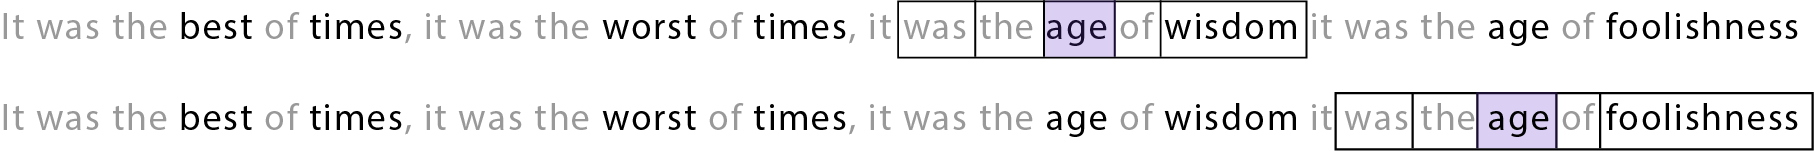

In [24]:
from IPython.display import Image 
Image(filename="best-of-times.png")

In [27]:
# part b - USE THE TEXT ABOVE TO COMPLETE EACH STRIPE
stripes = {'age':['wisdom','foolishness'], # example
           'best':['times'], # YOU FILL IN THE REST
           'foolishness':['age'],
           'times': ['best', 'worst'],
           'wisdom':['age'],
           'worst':['times']}

In [33]:
# part c - initializing an empty co-occurrence matrix (RUN THIS CELL AS IS)
co_matrix = pd.DataFrame({term: [0]*len(vocab) for term in vocab}, index = vocab, dtype=int)

In [34]:
# part c - FILL IN THE MISSING LINE so that this cell 1-hot encodes the co-occurrence matrix
for term, nbrs in stripes.items():
    for nbr in nbrs:
        ############# YOUR CODE HERE #################
        co_matrix[term][nbr] = 1
        ############# (END) YOUR CODE #################
co_matrix

,age,best,foolishness,times,wisdom,worst
age,0,0,1,0,1,0
best,0,0,0,1,0,0
foolishness,1,0,0,0,0,0
times,0,1,0,0,0,1
wisdom,1,0,0,0,0,0
worst,0,0,0,1,0,0


In [54]:
# part e - FILL IN THE MISSING LINES to compute the cosine similarity between each pair of terms
for term1, term2 in itertools.combinations(vocab, 2):
    # one hot-encoded vectors
    v1 = co_matrix[term1]
    v2 = co_matrix[term2]
    
    # cosine similarity
    ############# YOUR CODE HERE #################
    numerator = v1.mul(v2).sum()

    v1_sq_sum = v1.apply(lambda x: x ** 2).sum()
    v2_sq_sum = v2.apply(lambda x: x ** 2).sum()
    denominator = np.sqrt(v1_sq_sum*v2_sq_sum)
    
    csim = float(numerator/denominator)
    ############# (END) YOUR CODE #################    
    
    print(f"{term1}-{term2}: {csim}")

age-best: 0.0
age-foolishness: 0.0
age-times: 0.0
age-wisdom: 0.0
age-worst: 0.0
best-foolishness: 0.0
best-times: 0.0
best-wisdom: 0.0
best-worst: 1.0
foolishness-times: 0.0
foolishness-wisdom: 1.0
foolishness-worst: 0.0
times-wisdom: 0.0
times-worst: 0.0
wisdom-worst: 0.0


# Question 4: Pairs and Stripes at Scale

As you read in the paper by Zadeh et al, the advantage of metrics like Cosine, Dice, Overlap and Jaccard is that they are dimension independent -- that is to say, if we implement them in a smart way the computational complexity of performing these computations is independent of the number of documents we want to compare (or in our case, the number of terms that are potential synonyms). One component of a 'smart implementation' involves thinking carefully both about how you define the "basis vocabulary" that forms your feature set (removing stopwords, etc). Another key idea is to use a data structure that facilitates distributed calculations. The DISCO implemetation further uses a sampling strategy, but that is beyond the scope of this assignment. 

In this question we'll take a closer look at the computational complexity of the synonym detection approach we took in question 3 and then revist the document similarity example as a way to explore a more efficient approach to parallelizing this analysis.

### Q4 Tasks:

* __a) short response:__ In question 3 you calculated the cosine similarity of pairs of words using the vector representation of their co-occurrences in a corpus. Imagine for now that you have unlimited memory on each of your nodes and describe a sequence of map & reduce steps that would start from a raw corpus and reproduce your strategy from Q3. For each step be sure to note what information would be stored in memory on your nodes and what information would need to be shuffled over the network (a bulleted list of steps with 1-2 sentences each is sufficient to answer this question).

* __b) short response:__ In the asynch videos about "Pairs and Stripes" you were introduced to an alternative strategy. Explain two ways that using these data structures are more efficient than 1-hot encoded vectors when it comes to distributed similarity calculations [__`HINT:`__ _Consider memory constraints, amount of information being shuffled, amount of information being transfered over the network, and level of parallelization._]

* __c) read provided code:__ The code below provides a streamined implementation of Document similarity analysis in Spark. Read through this code carefully. Once you are confident you understand how it works, answer the remaining questions. [__`TIP:`__ _to see the output of each transformation try commenting out the subsequent lines and adding an early `collect()` action_.]

* __d) short response:__ The second mapper function, `splitWords`, emits 'postings'. The list of all 'postings' for a word is also refered to as an 'inverted index'. Define each of these terms based on your reading of the provided code.

* __e) short response:__ The third mapper, `makeCompositeKeys`, loops over the inverted index to emit 'pairs' of what? Explain what information is included in the composite key created at this stage and why it makes sense to synchronize around that information in the context of performing document similarity calculations. In addition to the information included in these new keys, what other piece of information will we need to compute Jaccard or Cosine similarity?

* __f) short response:__ Out of all the Spark transformations we make in this analysis, which are 'wide' transformations and which are 'narrow' transformations. Explain.

### Q4 Student Answers:
> __a)__  Steps to reproduce Q3 strategy with MapReduce:

* In the 1st MapReduce job, the raw corpus would be dispersed to the mappers which would output and send over the network pairs of non-stop words as keys and counts as values.  The reducers would receive these pairs, combine the count values in memory, and then save these to HDFS.

* In post processing, the word pair counts would be loaded into memory on a single machine, formed into a co-occurence matrix, and stored into HDFS.

* In the 2nd MapReduce job, the completed co-occurrence matrix would be dispersed to the mappers which would calculate a portion of the unique word combinations/pairs cosine similarity, then output and send over the network a word pair key and cosine similary value.  The reducers would save these values to HDFS.

> __b)__ One way that stripes are more efficient than pairs is in the network and shuffle overhead required.  The pairs strategy relies on complex combination keys while stripes rely on individual unique non-stop words for keys resulting in far less sorting and shuffling.  Another way that stripes are superior to pairs is in the parallelization permitted.  Since stripes are using a simple non-word key, keys can be aggregated to the same reducer much more easily than with the complex word pair keys.

> __c)__ _read provided code before answering d-f_ 

> __d)__ Based upon the code, a Posting is a tuple of the document ID and total # of words in the document.  The inverted index uses the word as the key (i.e. first element) while the posting is the value.  This is considered inverse since the input to the function is the document ID followed by its text.

> __e)__ This mapper is emitting pairs of documents that shared a word.  The pieces of information included in the composite key are the document ID and the total # of words for both documents.  This information is necessary for document similarity calculations as we will need the total # of words to make the calculation.   The other piece of information included is the value of 1 which will be useful when reducing by the composite key to determine the # of shared words between the documents which is required for Jaccard similarity calculation.  

> __f)__ The 2 wide transformations performed are reduceByKey as this transformation requires all of the data partitions to be in a specific way (i.e. by key), thus requiring a complex parent RDD structure with many dependencies.  The 4 narrow transformations performed are 3 flatMaps and 1 map.  These are considered narrow since they rely on a simple parent RDD structure with finite dependencies for execution.  

A small test file: __`sample_docs.txt`__

In [6]:
%%writefile sample_docs.txt
docA	bright blue butterfly forget
docB	best forget bright sky
docC	blue sky bright sun
docD	under butterfly sky hangs
docE	forget blue butterfly

Overwriting sample_docs.txt


__Document Similarity Analysis in Spark:__

In [7]:
# load data - RUN THIS CELL AS IS
data = sc.textFile("sample_docs.txt")  

In [8]:
# helper function - RUN THIS CELL AS IS
def splitWords(pair):
    """Mapper 2: tokenize each document and emit postings."""
    doc, text = pair
    words = text.split(" ")
    for w in words:
        yield (w, [(doc,len(words))])

In [9]:
# helper function - RUN THIS CELL AS IS
def makeCompositeKey(inverted_index):
    """Mapper 3: loop over postings and yield pairs."""
    word, postings = inverted_index
    # taking advantage of symmetry, output only (a,b), but not (b,a)
    for subset in itertools.combinations(sorted(postings), 2):
        yield (str(subset), 1)

In [10]:
# helper function - RUN THIS CELL AS IS
def jaccard(line):
    """Mapper 4: compute similarity scores"""
    (doc1, n1), (doc2, n2) = ast.literal_eval(line[0])
    total = int(line[1])
    jaccard = total / float(int(n1) + int(n2) - total)
    yield doc1+" - "+doc2, jaccard

In [84]:
# Spark Job - RUN THIS CELL AS IS
result = data.map(lambda line: line.split('\t')) \
             .flatMap(splitWords)  \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(makeCompositeKey) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(jaccard) \
             .takeOrdered(10, key=lambda x: -x[1])
result

[('docA - docE', 0.75),
 ('docA - docB', 0.3333333333333333),
 ('docA - docC', 0.3333333333333333),
 ('docB - docC', 0.3333333333333333),
 ('docD - docE', 0.16666666666666666),
 ('docC - docE', 0.16666666666666666),
 ('docB - docE', 0.16666666666666666),
 ('docC - docD', 0.14285714285714285),
 ('docA - docD', 0.14285714285714285),
 ('docB - docD', 0.14285714285714285)]

# About the Data
Now that you are comfortable with similarity metrics we turn to the main task in this assignment: Synonym Detection. As you saw in Question 3 the ability of our algorithm to detect words with similar meanings is highly dependent on our input text. Specifically, we need a large enough corpus of natural language that we can expose our algorithm to a realistic range of contexts in which in any given word might get used. Ideally, these 'contexts' would also provide enough signal to distinguish between words with similar semantic roles but different meaning. Finding such a corpus will be easier to accomplish for some words than others.

For the main task in this portion of the homework you will use data from Google's n-gram corpus. This data is particularly convenient for our task because Google has already done the first step for us: they windowed over a large subset of the web and extracted all 5-grams. If you are interested in learning more about this dataset the original source is: http://books.google.com/ngrams/, and a large subset is available [here from AWS](https://aws.amazon.com/datasets/google-books-ngrams/). 

For this assignment we have provided a subset of the 5-grams data consisting of 191 files of approximately 10MB each. These files are available on dropbox at: https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea
... below we provide the code to download these files. Please only use the provided data so that we can ensure consistent results from student to student.

Each row in our dataset represents one of these 5 grams in the format:
> `(ngram) \t (count) \t (pages_count) \t (books_count)`

__DISCLAIMER__: In real life, we would calculate the stripes cooccurrence data from the raw text by windowing over the raw text and not from the 5-gram preprocessed data.  Calculating pairs on this 5-gram is a little corrupt as we will be double counting cooccurences. Having said that this exercise can still pull out some similar terms. 

In [71]:
!mkdir data

In [72]:
# download the zipped data folder - RUN THIS CELL AS IS
!curl -L -o ngrams.zip https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea?dl=1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  829M    0  829M    0     0  5606k      0 --:--:--  0:02:31 --:--:-- 5739k


In [73]:
# unzip the data files into the data directory - RUN THIS CELL AS IS
!unzip -q ngrams.zip -d data

mapname:  conversion of  failed


In [6]:
# set global paths to full data folder and to the first file (which we'll use for testing)
NGRAMS = PWD + '/data'
F1_PATH = PWD + '/data/googlebooks-eng-all-5gram-20090715-0-filtered.txt'

As you develop your code you should use the following file to systems test each of your solutions before running it on the Google data. (Note: these are the 5-grams extracted from our two line Dickens corpus in Question 3... you should find that your Spark job results match the calculations we did "by hand").

Test file: __`systems_test.txt`__

In [7]:
%%writefile systems_test.txt
it was the best of	1	1	1
age of wisdom it was	1	1	1
best of times it was	1	1	1
it was the age of	2	1	1
it was the worst of	1	1	1
of times it was the	2	1	1
of wisdom it was the	1	1	1
the age of wisdom it	1	1	1
the best of times it	1	1	1
the worst of times it	1	1	1
times it was the age	1	1	1
times it was the worst	1	1	1
was the age of wisdom	1	1	1
was the best of times	1	1	1
was the age of foolishness	1	1	1
was the worst of times	1	1	1
wisdom it was the age	1	1	1
worst of times it was	1	1	1

Overwriting systems_test.txt


Finally, we'll create a Spark RDD for each of these files so that they're easy to access throughout the rest of the assignment.

In [8]:
# Spark RDDs for each dataset
testRDD = sc.textFile("systems_test.txt") 
f1RDD = sc.textFile(F1_PATH)
dataRDD = sc.textFile(NGRAMS)

Let's take a peak at what each of these RDDs looks like:

In [11]:
testRDD.take(10)

['it was the best of\t1\t1\t1',
 'age of wisdom it was\t1\t1\t1',
 'best of times it was\t1\t1\t1',
 'it was the age of\t2\t1\t1',
 'it was the worst of\t1\t1\t1',
 'of times it was the\t2\t1\t1',
 'of wisdom it was the\t1\t1\t1',
 'the age of wisdom it\t1\t1\t1',
 'the best of times it\t1\t1\t1',
 'the worst of times it\t1\t1\t1']

In [12]:
f1RDD.take(10)

['A BILL FOR ESTABLISHING RELIGIOUS\t59\t59\t54',
 'A Biography of General George\t92\t90\t74',
 'A Case Study in Government\t102\t102\t78',
 'A Case Study of Female\t447\t447\t327',
 'A Case Study of Limited\t55\t55\t43',
 "A Child's Christmas in Wales\t1099\t1061\t866",
 'A Circumstantial Narrative of the\t62\t62\t50',
 'A City by the Sea\t62\t60\t49',
 'A Collection of Fairy Tales\t123\t117\t80',
 'A Collection of Forms of\t116\t103\t82']

In [13]:
dataRDD.take(10)

['A BILL FOR ESTABLISHING RELIGIOUS\t59\t59\t54',
 'A Biography of General George\t92\t90\t74',
 'A Case Study in Government\t102\t102\t78',
 'A Case Study of Female\t447\t447\t327',
 'A Case Study of Limited\t55\t55\t43',
 "A Child's Christmas in Wales\t1099\t1061\t866",
 'A Circumstantial Narrative of the\t62\t62\t50',
 'A City by the Sea\t62\t60\t49',
 'A Collection of Fairy Tales\t123\t117\t80',
 'A Collection of Forms of\t116\t103\t82']

# Question 5: N-gram EDA part 1 (words)

Before starting our synonym-detection, let's get a sense for this data. As you saw in questions 3 and 4 the size of the vocabulary will impact the amount of computation we have to do. Write a Spark job that will accomplish the three tasks below as efficiently as possible. (No credit will be awarded for jobs that sort or subset after calling `collect()`-- use the framework to get the minimum information requested). As you develop your code, systems test each job on the provided file with Dickens ngrams, then on a single file from the Ngram dataset before running the full analysis.


### Q5 Tasks:
* __a) code:__ Write a Spark job to retrieve:
  * The number of unique words that appear in the data. (i.e. size of the vocabulary) 
  * A list of the top 10 words & their counts.
  * A list of the bottom 10 words & their counts.  
  
  __`NOTE  1:`__ _don't forget to lower case the ngrams before extracting words._  
  __`NOTE  2:`__ _don't forget to take in to account the number of occurances of each ngram._  
  __`NOTE  3:`__ _to make this code more reusable, the `EDA1` function code base uses a parameter 'n' to specify the number of top/bottom words to print (in this case we've requested 10)._


* __b) short response:__ Given the vocab size you found in part a, how many potential synonym pairs could we form from this corpus? If each term's stripe were 1000 words long, how many individual 'postings' tuples would we need to shuffle inorder to form the inverted indices? Show and briefly explain your calculations for each part of this question. [__`HINT:`__ see your work from q4 for a review of these concepts.]

* __c) short response:__ What do you notice about the most frequent words, how usefull will these top words be in synonym detection? Explain.

* __d) short response:__ What do you notice/infer about the least frequent words, how reliable should we expect the detected 'synonyms' for the bottom words to be? Explain.

### Q5 Student Answers:

> __b)__ The potential synonym pairs can be calculated with the following equation from Q3: $pairs(n) = n(n-1)/2$  By plugging in our vocab size of 269339, we could have $pairs(269339) = 269339(269339-1)/2 = 36.2B$ pairs.  The individual 'postings' tuples needed would be $1000(1000-1)/2 = 499,500 $ in order to form the inverted indices.  

> __c)__ The top words are all prepositions and conjunctions which are not particularly useful for synonym detection.  These words are commonplace when creating sentences, therefore their marginal value to synonym detection is essentially none.    

> __d)__ The bottom words are misspellings of possible synonym words and/or are words don't appear in the dictionary.  I would expect these words to be unreliable for synonym detection since they largely seem to be erroneous words to begin with, and are essentially overfit to the words in the 1 or 2 sentences they appear in.

In [9]:
# part a - write your spark job here 
def EDA1(rdd, n):
    total, top_n, bottom_n = None, None, None
    ############# YOUR CODE HERE ###############
    
    # Transformations
    word_count_rdd = rdd.map(lambda line: line.split('\t')[0]).flatMap(lambda x: x.split(" ")). \
        map(lambda x: (x.lower(),1)).reduceByKey(lambda x,y: x+y)
    
    # Actions
    total = word_count_rdd.count()
    top_n = word_count_rdd.takeOrdered(n, key=lambda x: -x[1])
    bottom_n = word_count_rdd.takeOrdered(n, key=lambda x: x[1])
    
    ############# (END) YOUR CODE ##############
    return total, top_n, bottom_n

In [15]:
# part a - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(testRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 2.6843056678771973 seconds


In [16]:
# part a - run a single file (RUN THIS CELL AS IS)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(f1RDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 4.519266843795776 seconds


In [17]:
# part a - run full analysis (RUN THIS CELL AS IS)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(dataRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 359.9732189178467 seconds


In [18]:
# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 269339
 ---- Top Words ----|--- Bottom Words ----
     the   27502442 |     paedagogik   1
      of   18191779 |            trg   1
      to   12075971 |     signficant   1
      in    7881239 |      ribiera's   1
       a    7853465 |         angwin   1
     and    7767900 | socioreligious   1
    that    4316884 |         ferons   1
      is    3847383 |            dpa   1
      be    3288731 |           orco   1
     for    2763613 |         atropa   1


__Expected output:__  
_(bottom words might vary a little due to ties)._
<table>
<th>Top Words</th>
<th>Bottom Words</th>
<tr><td><pre>
the 5490815394
of 3698583299
to 2227866570
in 1421312776
a 1361123022
and 1149577477
that  802921147
is  758328796
be  688707130
as  492170314
</pre></td>
<td><pre>
foretastes  40
parcival  40
schwetzingen  40
cras  40
 scholared  40
scribbler's  40
washermen  40
viscerating  40
unmurmuring  40
mildes  40
</pre></td></tr>
</table>

# Question 6: N-gram EDA part 2 (co-occurrences)

The computational complexity of synonym analysis depends not only on the number of words, but also on the number of co-ocurrences each word has. In this question you'll take a closer look at that aspect of our data. As before, please test each job on small "systems test" (Dickens ngrams) file and on a single file from the Ngram dataset before running the full analysis.

### Q6 Tasks:
* __a) code:__ Write a spark job that computes:
  * the number of unique neighbors (i.e. 5-gram co-occuring words) for each word in the vocabulary. 
  * the top 10 words with the most "neighbors"
  * the bottom 10 words with least "neighbors"
  * a random sample of 1% of the words' neighbor counts  
  __`NOTE:`__ for the last item, please return only the counts and not the words -- we'll go on to use these in a plotting function that expects a list of integers.


* __b) short response:__ Use the provided code to plot a histogram of the sampled list from `a`. Comment on the distribution you observe. How will this distribution affect our synonym detection analysis?

* __c) code + short response:__ Write a Spark Job to compare the top/bottom words from Q5 and from part a. Specifically, what % of the 1000 most/least neighbors words also appear in the list of 1000 most/least frequent words. [__`NOTE:`__ _technically these lists are short enough to comparing in memory on your local machine but please design your Spark job as if we were potentially comparing much larger lists._]

### Q6 Student Answers:

> __b)__ The distribution of both graphs is skewed to the left signifying that there are words with too many and few neighbors.  This distribution will result in the few neighbor words being overfit to the few words they are neighboring during the synonym detection analysis.  Furthermore, the the too many neighbor words will be not useful for synonym detection as they will be neighbors with most other words.

> __c)__ Of the 1000 words with most neighbors, 0.884 percent are also in the list of 1000 most frequent words.
Of the 1000 words with least neighbors, 0.09 percent are also in the list of 1000 least frequent words.  

In [10]:
# part a - spark job
def EDA2(rdd,n):
    top_n, bottom_n, sampled_counts = None, None, None
    ############# YOUR CODE HERE ###############
    
    def splitWords(text):
        words = text.split('\t')[0].split(" ")
        for cur in words:
            other_words = text.split('\t')[0].split(" ")
            other_words.remove(cur)
            for word in other_words:
                if cur != word:
                    yield (cur.lower()+'_'+word.lower(), 1)
    
    # Transformations
    unique_neighbors_rdd = rdd.flatMap(splitWords).reduceByKey(lambda x,y: x+y). \
        map(lambda x: (x[0].split('_')[0], 1)).reduceByKey(lambda x,y: x+y).cache()

    count = unique_neighbors_rdd.count()
    sampled_counts = unique_neighbors_rdd.map(lambda x: x[1]).takeSample(False, int(count*.01))
    top_n = unique_neighbors_rdd.takeOrdered(n, key=lambda x: -x[1])
    bottom_n = unique_neighbors_rdd.takeOrdered(n, key=lambda x: x[1])
    
    ############# (END) YOUR CODE ##############
    return top_n, bottom_n, sampled_counts

In [11]:
# part a - systems test (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(testRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 4.113733768463135 seconds


In [12]:
# part a - single file test (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(f1RDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 9.583759784698486 seconds


In [13]:
# part a - full data (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(dataRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 1332.9711916446686 seconds


In [14]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

 --- Most Co-Words ---|--- Least Co-Words ----
         the   164983 |          cococo    1
          of   155709 |            inin    1
         and   132815 |        oooooooo    1
          in   110616 |        charuhas    1
          to    94359 |         ooooooo    1
           a    89198 |           iiiii    1
          by    67267 |          iiiiii    1
        with    65128 |             cnj    1
        that    61175 |            choh    1
          as    60653 |             neg    1


__Part a expected output:__  
_(bottom words might vary a little due to ties)._
<table>
<th>Most Neighbors</th>
<th>Least Neighbors</th>
<tr><td><pre>
the   164982 
of   155708 
and   132814 
in   110615 
to    94358 
a    89197
by    67266
with    65127
that    61174
as    60652
</pre></td>
<td><pre>
cococo    1
inin    1
charuhas    1
ooooooo    1
iiiii    1
iiiiii    1
cnj    1
choh    1
neg    1
cococococo    1
</pre></td></tr>
</table>

__`NOTE:`__ _before running the plotting code below, make sure that the variable_ `sample_counts` _points to the list generated in_ `part a`.

NOTE: we'll exclude the 6 words with more than 6000 nbrs in this 2687 count sample.


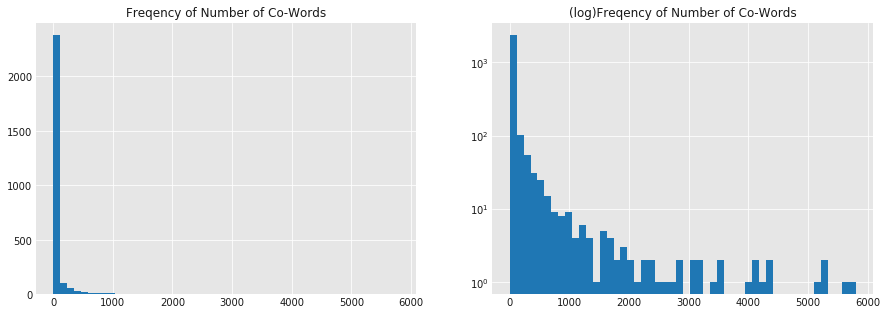

In [14]:
# part b - plot histogram (RUN THIS CELL AS IS - feel free to modify format)

# removing extreme upper tail for a better visual
counts = np.array(sample_counts)[np.array(sample_counts) < 6000]
t = sum(np.array(sample_counts) > 6000)
n = len(counts)
print("NOTE: we'll exclude the %s words with more than 6000 nbrs in this %s count sample." % (t,n))

# set up figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

# plot regular hist
ax1.hist(counts, bins=50)
ax1.set_title('Freqency of Number of Co-Words', color='0.1')
ax1.set_facecolor('0.9')
ax1.tick_params(axis='both', colors='0.1')
ax1.grid(True)

# plot log scale hist
ax2.hist(counts, bins=50)
ax2.set_title('(log)Freqency of Number of Co-Words', color='0.1')
ax2.set_facecolor('0.9')
ax2.tick_params(axis='both', colors='0.1')
ax2.grid(True)
plt.yscale('log')

plt.show()

In [18]:
# part c - spark job
def compareRankings(rdd1, rdd2):
    percent_overlap = None
    ############# YOUR CODE HERE ###############

    individual = rdd1.count()
    
    # Inner join only will return results with key from both RDDs
    shared = rdd1.join(rdd2).count()

    percent_overlap = shared / individual
    
    ############# (END) YOUR CODE ##############
    return percent_overlap

In [19]:
# part c - get lists for comparison (RUN THIS CELL AS IS...)
# (... then change 'testRDD' to 'f1RDD'/'dataRDD' when ready)
total, topWords, bottomWords = EDA1(dataRDD, 1000)
topNbrs, bottomNbrs, sample_counts = EDA2(dataRDD, 1000)
twRDD = sc.parallelize(topWords)
bwRDD = sc.parallelize(bottomWords)
tnRDD = sc.parallelize(topNbrs)
bnRDD = sc.parallelize(bottomNbrs)
top_overlap = compareRankings(tnRDD, twRDD)
bottom_overlap = compareRankings(bnRDD, bwRDD)
print(f"Of the 1000 words with most neighbors, {top_overlap} percent are also in the list of 1000 most frequent words.")
print(f"Of the 1000 words with least neighbors, {bottom_overlap} percent are also in the list of 1000 least frequent words.")

Of the 1000 words with most neighbors, 0.884 percent are also in the list of 1000 most frequent words.
Of the 1000 words with least neighbors, 0.09 percent are also in the list of 1000 least frequent words.


# Question 7: Basis Vocabulary & Stripes

Every word that appears in our data is a potential feature for our synonym detection analysis. However as we've discussed, some are likely to be more useful than others. In this question, you'll choose a judicious subset of these words to form our 'basis vocabulary' (i.e. feature set). Practically speaking, this means that when we build our stripes, we are only going to keep track of when a term co-occurs with one of these basis words. 


### Q7 Tasks:
* __a) short response:__ Suppose we were deciding between two different basis vocabularies: the 1000 most frequent words or the 1000 least frequent words. How would this choice impact the quality of the synonyms we are able to detect? How does this choice relate to the ideas of 'overfitting' or 'underfitting' a training set?

* __b) short response:__ If we had a much larger dataset, computing the full ordered list of words would be extremely expensive. If we need to none-the-less get an estimate of word frequency in order to decide on a basis vocabulary (feature set), what alternative strategy could we take?

* __c) code:__ Write a spark job that does the following:
  * tokenizes, removes stopwords and computes a word count on the ngram data
  * subsets the top 10,000 words (these are the terms we'll consider as potential synonyms)
  * subsets words 9,000-9,999 (this will be our 1,000 word basis vocabulary)    
  (to put it another way - of the top 10,000 words, the bottom 1,000 form the basis vocabulary)
  * saves the full 10K word list and the 1K basis vocabulary to file for use in `d`.  
  
  __NOTE:__ _to ensure consistency in results please use only the provided list of stopwords._  
  __NOTE:__ _as always, be sure to test your code on small files as you develop it._  

* __d) code:__ Write a spark job that builds co-occurrence stripes for the top 10K words in the ngram data using the basis vocabulary you developed in `part c`. This job/function, unlike others so far, should return an RDD (which we will then use in q8).

### Q7 Student Answers:
> __a)__ The 1000 most frequent words being used as a basis vocabulary would result in underfitting synonym words since these words most likely occur with the majority of other words.  The 1000 least frequent words being used as a basis vocabulary would result in overfitting synonym words since there are only a few words to train against, ultimately yielding results which won't generalize well.  

> __b)__ One alternative strategy we could take is sampling from our larger dataset in order to gain an estimation of the word frequencies.  The strategy would include random sampling from the corpus, running through the same EDA functions from Q5 and Q6, then extrapolating the frequency estimation from the sample word frequencies.  

In [15]:
# part c - provided stopwords (RUN THIS CELL AS IS)
STOPWORDS =  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
              'ourselves', 'you', 'your', 'yours', 'yourself', 
              'yourselves', 'he', 'him', 'his', 'himself', 'she', 
              'her', 'hers', 'herself', 'it', 'its', 'itself', 
              'they', 'them', 'their', 'theirs', 'themselves', 
              'what', 'which', 'who', 'whom', 'this', 'that', 
              'these', 'those', 'am', 'is', 'are', 'was', 'were', 
              'be', 'been', 'being', 'have', 'has', 'had', 'having', 
              'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 
              'but', 'if', 'or', 'because', 'as', 'until', 'while', 
              'of', 'at', 'by', 'for', 'with', 'about', 'against', 
              'between', 'into', 'through', 'during', 'before', 
              'after', 'above', 'below', 'to', 'from', 'up', 'down', 
              'in', 'out', 'on', 'off', 'over', 'under', 'again', 
              'further', 'then', 'once', 'here', 'there', 'when', 
              'where', 'why', 'how', 'all', 'any', 'both', 'each', 
              'few', 'more', 'most', 'other', 'some', 'such', 'no', 
              'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
              'too', 'very', 'should', 'can', 'now', 'will', 'just', 
              'would', 'could', 'may', 'must', 'one', 'much', "it's",
              "can't", "won't", "don't", "shouldn't", "hasn't"]

In [16]:
# part c - spark job
def get_vocab(rdd, n_total, n_basis):
    vocab, basis = None, None
    ############# YOUR CODE HERE ###############

    stop_words = sc.broadcast(set(STOPWORDS))
    
    def splitWords(text):
        words = text.split('\t')[0].split(" ")
        for word in words:
            lower_word = word.lower()
            if lower_word not in stop_words.value:
                yield (lower_word, 1)
    
    whole_vocab_rdd = rdd.flatMap(splitWords).reduceByKey(lambda x,y: x+y).cache()

    # Grab top n vocab
    top_vocab = whole_vocab_rdd.takeOrdered(n_total, key=lambda x: -x[1])
    vocab_rdd = sc.parallelize(top_vocab)
    
    # Grab bottom n words of top n vocab
    basis_vocab = vocab_rdd.takeOrdered(n_basis, key=lambda x: x[1])
    basis_rdd = sc.parallelize(basis_vocab)

    # Collect words as arrays
    vocab = vocab_rdd.map(lambda x: x[0]).collect()
    basis = basis_rdd.map(lambda x: x[0]).collect()

    ############# (END) YOUR CODE ##############
    return vocab, basis

In [17]:
# part c - run your job (replace 'testRDD' with 'f1RDD'/'dataRDD' when ready)
VOCAB, BASIS = get_vocab(dataRDD, 10000, 1000)

In [18]:
# part c - save to file (RUN THIS CELL AS IS)
with open("vocabulary.txt", "w") as file:
    file.write(str(VOCAB))
with open("basis.txt", "w") as file:
    file.write(str(BASIS))

In [19]:
# part d - spark job
def buildStripes(rdd, vocab, basis):
    stripesRDD = None
    ############# YOUR CODE HERE ###############

    vocab_b = sc.broadcast(set(vocab))
    basis_b = sc.broadcast(set(basis))
    
    def splitWords(text):
        words = text.split('\t')[0].split(" ")
        for cur in words:
            cur_lower = cur.lower()
            
            # Check if current word is in VOCAB
            if cur_lower in vocab_b.value:
                other_words = text.split('\t')[0].split(" ")
                other_words.remove(cur)
                
                # Create new set for appending words in BASIS
                new_set = set()
                for word in other_words:
                    other_lower = word.lower()
                    if other_lower in basis_b.value:
                        new_set.add(other_lower)
                
                # Yield a stripe if the new set is not empty
                if len(new_set) > 0:
                    yield (cur_lower, new_set)
    
    stripesRDD = rdd.flatMap(splitWords).reduceByKey(lambda x,y: x|y)#.map(lambda x: (x[0], len(x[1])))
    
    ############# (END) YOUR CODE ##############
    return stripesRDD

In [20]:
# part d - run your systems test (RUN THIS CELL AS IS)
VOCAB, BASIS = get_vocab(testRDD, 10, 10)
testStripesRDD = buildStripes(testRDD, VOCAB, BASIS)
start = time.time()
testStripesRDD.top(10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 0.1323866844177246 seconds


In [21]:
# part d - run your single file test (RUN THIS CELL AS IS)
VOCAB = ast.literal_eval(open("vocabulary.txt", "r").read())
BASIS = ast.literal_eval(open("basis.txt", "r").read())
f1StripesRDD = buildStripes(f1RDD, VOCAB, BASIS)
start = time.time()
f1StripesRDD.top(5)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 2.169090986251831 seconds


In [22]:
# part d - run the full analysis (RUN THIS CELL AS IS)
VOCAB = ast.literal_eval(open("vocabulary.txt", "r").read())
BASIS = ast.literal_eval(open("basis.txt", "r").read())
stripesRDD = buildStripes(dataRDD, VOCAB, BASIS).cache()

In [23]:
# part d - take a look at a few stripes (RUN THIS CELL AS IS)
start = time.time()
for wrd, stripe in stripesRDD.top(3):
    print(wrd)
    print(list(stripe))
    print('-------')
print("Wall time: {} seconds".format(time.time() - start))

zones
['subdivided', 'adhesion', 'environments', 'flora', 'guarantees', 'necrosis', 'buffer', 'saturation', 'earthquake', 'unification', 'projecting', 'cortical']
-------
zone
['fringe', 'prostate', 'avoidance', 'perpetually', 'persia', 'subdivided', 'inorganic', 'defines', 'necrosis', 'evacuation', 'turbulent', 'legality', 'characterised', 'lust', 'delta', 'au', 'exposing', 'invade', 'illuminated', 'narrower', 'auxiliary', 'fibrous', 'buffer', 'excitation', 'pulp', 'earthquake', 'philippine', 'diminishing', 'ie', 'oregon', 'tribal', 'masculine', 'nutrients', 'originate', 'lymphocytes', 'contamination', 'sands', 'hairs', 'cytoplasm', 'saturation', 'stillness', 'cortical']
-------
zinc
['metallic', 'ammonium', 'radioactive', 'soda', 'iodine', 'transcription', 'weighing', 'inhibit', 'condensed', 'dysfunction', 'container', 'electrodes', 'phosphorus', 'pancreas', 'nitrate', 'dipped', 'catalyst', 'alcoholic', 'sulphur', 'insoluble', 'acetic', 'cleaning', 'abruptly']
-------
Wall time: 243.

In [25]:
# part d - save your full stripes to file for ease of retrival later... (OPTIONAL)
stripesRDD.saveAsTextFile(PWD + '/stripes')

# Question 8: Synonym Detection

We're now ready to perform the main synonym detection analysis. In the tasks below you will compute cosine, jaccard, dice and overlap similarity measurements for each pair of words in our vocabulary and then sort your results to find the most similar pairs of words in this dataset. __`IMPORTANT:`__ When you get to the sorting step please __sort on cosine similarity__ only, so that we can ensure consistent results from student to student. 

Remember to test each step of your work with the small files before running your code on the full dataset. This is a computationally intense task: well designed code can be the difference between a 20min job and a 2hr job. __`NOTE:`__ _as you are designing your code you may want to review questions 3 and 4 where we modeled some of the key pieces of this analysis._

### Q8 Tasks:
* __a) short response:__ In question 7 you wrote a function that would create word stripes for each `term` in our vocabulary. These word stripes are essentially an 'embedded representation' of the `term`'s meaning. What is the 'feature space' for this representation? (i.e. what are the features of our 1-hot encoded vectors?). What is the maximum length of a stripe?

* __b) short response:__ Remember that we are going to treat these stripes as 'documents' and perform similarity analysis on them. The first step is to emit postings which then get collected to form an 'inverted index.' How many rows will there be in our inverted index? Explain.

* __c) short response:__ In the demo from question 2, we were able to compute the cosine similarity directly from the stripes (we did this using their vector form, but could have used the list instead). So why do we need the inverted index? (__`HINT:`__ _see your answer to Q4a & Q4b_)

* __d) code:__ Write a spark job that does the following:
  * loops over the stripes from Q7 and emits postings for the `term` (_remember stripe = document_)
  * aggregates the postings to create an inverted index
  * loops over all pairs of `term`s that appear in the same inverted index and emits co-occurrence counts
  * aggregates co-occurrences
  * uses the counts (along with the accompanying information) to compute the cosine, jacard, dice and overlap similarity metrics for each pair of words in the vocabulary 
  * retrieve the top 20 and bottom 20 most/least similar pairs of words
  * also returned the cached sorted RDD for use in the next question  
  __`NOTE 1`:__ _Don't forget to include the stripe length when you are creating the postings & co-occurrence pairs. A composite key is the way to go here._  
  __`NOTE 2`:__ _Please make sure that your final results are sorted according to cosine similarity otherwise your results may not match the expected result & you will be marked wrong._
  
* __e) code:__ Comment on the quality of the "synonyms" your analysis comes up with. Do you notice anything odd about these pairs of words? Discuss at least one idea for how you might go about improving on the analysis.

### Q8 Student Answers:
> __a)__ The feature space for our word stripes is co-occurring terms for a given word.  The dimensionality of our feature space is 1 x n where n is the basis size of 1000. The maximum of length of a stripe will be the basis size which was set to 1000 in Q7.  

> __b)__ The inverted index will have the same number of rows as our stripes (i.e. the basis size of 1000).  The row count remains the same since we are combining the co-occuring words (i.e. values) into a composite key, thus the values have become the indexes.  As such, there are no rows that will be created or removed.   

> __c)__ The inverted index is required since we will be working with a much larger dataset.  This key/value approach will significantly reduce the # of keys to shuffled since the inverted index utilizes composite keys.  Our MapReduce jobs would take substantially longer to finish without the composite keys provided by the inverted index.  

> __e)__ Upon inspection, the synonyms from the analysis seem fairly intuitively accurate.  I found it amusing that los and angeles were considerd the highest likelihood pair of synonyms from my results (although this differs from the provided output presumably intentionally).  The most highly similar words are variants of the same few words (e.g. time, well, first).  One idea for how to address this issue is to penalize words that have already been assigned another synonym, so it will be less likely to have words with multiple synonyms.  This approach breaks down for legitimate words with multiple synonyms though.  In our case, these words are still commonplace and could be added to the stop words list as an alternative.  


In [26]:
# helper function for pretty printing (RUN THIS CELL AS IS)
def displayOutput(lines):
    template = "{:25}|{:6}, {:7}, {:7}, {:5}"
    print(template.format("Pair", "Cosine", "Jaccard", "Overlap", "Dice"))
    for pair, scores in lines:
        scores = [round(s,4) for s in scores]
        print(template.format(pair, *scores))

__`TIP:`__ Feel free to define helper functions within the main function to help you organize your code. Readability is important! Eg:
```
def similarityAnlysis(stripesRDD):
    """main docstring"""
    
    simScoresRDD, top_n, bottom_n = None, None, None
    
    ############ YOUR CODE HERE ###########
    def helper1():
        """helper docstring"""
        return x
        
    def helper2():
        """helper docstring"""
        return x
        
    # main spark job starts here
    
        ...etc
    ############ (END) YOUR CODE ###########
    return simScoresRDD, top_n, bottom_n
```


In [27]:
# part d - write your spark job in the space provided
def similarityAnalysis(stripesRDD, n):
    """
    This function defines a Spark DAG to compute cosine, jaccard, 
    overlap and dice scores for each pair of words in the stripes
    provided. 
    
    Output: an RDD, a list of top n, a list of bottom n
    """
    simScoresRDD, top_n, bottom_n = None, None, None
    
    ############### YOUR CODE HERE ################
   
    def splitWords(pair):
        """Mapper 2: tokenize each document and emit postings."""
        doc, words = pair
        for w in words:
            yield (w, [(doc,len(words))])

    def makeCompositeKey(inverted_index):
        """Mapper 3: loop over postings and yield pairs."""
        word, postings = inverted_index
        for subset in itertools.combinations(sorted(postings), 2):
            yield (str(subset), 1)

    def similarities(line):
        """Mapper 4: compute similarity scores"""
        (doc1, n1), (doc2, n2) = ast.literal_eval(line[0])
        total = int(line[1])
        
        cosine = total / float(np.sqrt(n1) * np.sqrt(n2))
        jaccard = total / float(int(n1) + int(n2) - total) 
        overlap = total / float(min(n1, n2))
        dice = (2 * total) / float(int(n1) + int(n2))
        yield (doc1+" - "+doc2, [cosine, jaccard, overlap, dice])

    result = stripesRDD.flatMap(splitWords)  \
                       .reduceByKey(lambda x,y : x+y) \
                       .flatMap(makeCompositeKey) \
                       .reduceByKey(lambda x,y : x+y) \
                       .flatMap(similarities)
    
    top_n = result.takeOrdered(n, key=lambda x: -x[1][0])
    bottom_n = result.takeOrdered(n, key=lambda x: x[1][0])

    ############### (END) YOUR CODE ##############
    return result, top_n, bottom_n

In [28]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
testResult, top_n, bottom_n = similarityAnalysis(testStripesRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 0.6676108837127686 seconds


In [29]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
f1Result, top_n, bottom_n = similarityAnalysis(f1StripesRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 2.0557198524475098 seconds


In [30]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
result, top_n, bottom_n = similarityAnalysis(stripesRDD, 20)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 884.8115451335907 seconds


In [31]:
# part d - display the results (RUN THIS CELL AS IS)
print("MOST SIMILAR:")
displayOutput(top_n)
print("")
print("LEAST SIMILAR:")
displayOutput(bottom_n)

MOST SIMILAR:
Pair                     |Cosine, Jaccard, Overlap, Dice 
angeles - los            |0.9271,  0.8636,    0.95, 0.9268
time - well              |0.8983,  0.8152,  0.9119, 0.8982
first - time             |0.8963,  0.8113,  0.9262, 0.8958
time - upon              |0.8717,  0.7709,  0.9154, 0.8706
first - well             |0.8708,  0.7709,  0.8864, 0.8706
part - time              |0.8683,  0.7653,  0.9169, 0.8671
great - time             | 0.866,  0.7603,  0.9293, 0.8638
part - well              |0.8615,  0.7557,  0.8961, 0.8608
made - time              |0.8572,  0.7469,  0.9193, 0.8551
upon - well              |0.8568,  0.7487,  0.8863, 0.8563
time - way               |0.8566,  0.7451,  0.9268, 0.8539
new - time               |0.8564,  0.7446,   0.929, 0.8536
time - two               |0.8497,  0.7349,   0.917, 0.8472
great - well             |0.8457,  0.7307,  0.8939, 0.8444
also - well              |0.8444,  0.7282,  0.8988, 0.8427
great - upon             |0.8439,  0.7297, 

__Expected output:__  
<table>
<th>Most Similar</th>
<th>Least Similar</th>
<tr><td><pre>
Pair           |Cosine, Jaccard, Overlap, Dice 
first - time   |  0.89,  0.8012,  0.9149, 0.8897
time - well    |0.8895,   0.801,   0.892, 0.8895
great - time   | 0.875,  0.7757,   0.925, 0.8737
part - well    | 0.874,  0.7755,  0.9018, 0.8735
first - well   |0.8717,  0.7722,  0.8936, 0.8715
part - time    |0.8715,  0.7715,  0.9018, 0.871
time - upon    |0.8668,   0.763,  0.9152, 0.8656
made - time    | 0.866,  0.7619,  0.9109, 0.8649
made - well    |0.8601,  0.7531,  0.9022, 0.8592
time - way     |0.8587,  0.7487,  0.9259, 0.8563
great - well   |0.8526,  0.7412,  0.8988, 0.8514
time - two     |0.8517,  0.7389,  0.9094, 0.8498
first - great  |0.8497,  0.7381,  0.8738, 0.8493
first - part   |0.8471,  0.7348,  0.8527, 0.8471
great - upon   |0.8464,  0.7338,  0.8475, 0.8464
upon - well    |0.8444,   0.729,   0.889, 0.8433
new - time     |0.8426,   0.724,  0.9133, 0.8399
first - two    |0.8411,  0.7249,  0.8737, 0.8405
way - well     |0.8357,  0.7146,  0.8986, 0.8335
time - us      |0.8357,  0.7105,  0.9318, 0.8308
</pre></td>
<td><pre>
Pair                  |Cosine, Jaccard, Overlap, Dice 
region - write        |0.0067,  0.0032,  0.0085, 0.0065
relation - snow       |0.0067,  0.0026,  0.0141, 0.0052
cardiac - took        |0.0074,  0.0023,  0.0217, 0.0045
ever - tumor          |0.0076,   0.002,  0.0263, 0.004
came - tumor          |0.0076,   0.002,  0.0263, 0.004
let - therapy         |0.0076,   0.003,  0.0161, 0.0059
related - stay        |0.0078,  0.0036,  0.0116, 0.0072
factors - hear        |0.0078,  0.0039,  0.0094, 0.0077
implications - round  |0.0078,  0.0033,  0.0145, 0.0066
came - proteins       |0.0079,   0.002,  0.0286, 0.0041
population - window   |0.0079,  0.0039,    0.01, 0.0077
love - proportional   | 0.008,  0.0029,  0.0185, 0.0058
got - multiple        | 0.008,  0.0034,  0.0149, 0.0067
changes - fort        |0.0081,  0.0032,  0.0161, 0.0065
layer - wife          |0.0081,  0.0038,  0.0119, 0.0075
five - sympathy       |0.0081,  0.0034,  0.0149, 0.0068
arrival - essential   |0.0081,   0.004,  0.0093, 0.008
desert - function     |0.0081,  0.0031,  0.0175, 0.0062
fundamental - stood   |0.0081,  0.0038,  0.0115, 0.0077
patients - plain      |0.0081,   0.004,  0.0103, 0.0079
</pre></td></tr>
</table>

### Congratulations, you've completed HW3! Please see the readme file for submission instructions.